In [321]:
#établir la connexion avec google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [322]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [323]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [324]:
from pyspark.sql import SparkSession
import openpyxl

In [325]:
import pandas as pd
data=pd.read_excel('.../estimation_immo.xlsx')
data

,Prix,Description,Surface,Adresse
0,295 000 €,Appartement 3 pièces à vendre,"61,68 m²",BAYONNE (64100)
1,490 000 €,Appartement 4 pièces à vendre,87 m²,BORDEAUX (33000)
2,320 000 €,Appartement 3 pièces à vendre,"71,52 m²",Biarritz (64200)
3,269 000 €,Appartement 2 pièces à vendre,47 m²,ANGLET (64600)
4,225 000 €,Appartement 2 pièces à vendre,"47,54 m²",BIARRITZ (64200)
...,...,...,...,...
1045,216 500 €,Appartement 2 pièces à vendre,28 m²,LE LAVANDOU (83980)
1046,249 000 €,Appartement 2 pièces à vendre,28 m²,Le lavandou (83980)
1047,255 000 €,Appartement 2 pièces à vendre,27 m²,LE LAVANDOU (83980)
1048,532 000 €,Appartement 2 pièces à vendre,60 m²,Cannes (06400)


In [326]:
book = openpyxl.load_workbook(".../estimation_immo.xlsx")

sheet = book.active
data = [[cell.value for cell in row] for row in sheet.rows]
col_names = data[0]
data = data[1:]

In [327]:
spark=SparkSession.builder.appName('Projet_immo').getOrCreate()

In [328]:
# Création d'un DataFrame à partir des données
df = spark.createDataFrame(data, schema=col_names)
df.show()

+---------+--------------------+--------+-----------------+
|     Prix|         Description| Surface|          Adresse|
+---------+--------------------+--------+-----------------+
|295 000 €|Appartement 3 piè...|61,68 m²|  BAYONNE (64100)|
|490 000 €|Appartement 4 piè...|   87 m²| BORDEAUX (33000)|
|320 000 €|Appartement 3 piè...|71,52 m²| Biarritz (64200)|
|269 000 €|Appartement 2 piè...|   47 m²|   ANGLET (64600)|
|225 000 €|Appartement 2 piè...|47,54 m²| BIARRITZ (64200)|
|195 000 €|Appartement 2 piè...|   46 m²|  BAYONNE (64100)|
|211 000 €|Appartement 2 piè...|43,73 m²|  LAHONCE (64990)|
|312 000 €|Appartement 3 piè...|   62 m²| BORDEAUX (33300)|
|125 000 €|Appartement 4 piè...|  100 m²|PERIGUEUX (24000)|
|512 000 €|Appartement 3 piè...|67,55 m²| BORDEAUX (33000)|
|288 700 €|Appartement 5 piè...|101,7 m²|ROCHEFORT (17300)|
|299 000 €|Appartement 3 piè...|   64 m²|ARCANGUES (64200)|
|181 619 €|Appartement 2 piè...|48,26 m²|    Royan (17200)|
|185 000 €|Appartement 4 piè...|   69 m²

In [329]:
# verifier si il y'a des valeurs manquantes
from pyspark.sql.functions import *
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----------+-------+-------+
|Prix|Description|Surface|Adresse|
+----+-----------+-------+-------+
|   0|          0|      0|      0|
+----+-----------+-------+-------+



In [330]:
# Supprimer les symboles monetaires
df = df.withColumn("Prix", regexp_replace(col("Prix"), "€", ""))
df.show()

+--------+--------------------+--------+-----------------+
|    Prix|         Description| Surface|          Adresse|
+--------+--------------------+--------+-----------------+
|295 000 |Appartement 3 piè...|61,68 m²|  BAYONNE (64100)|
|490 000 |Appartement 4 piè...|   87 m²| BORDEAUX (33000)|
|320 000 |Appartement 3 piè...|71,52 m²| Biarritz (64200)|
|269 000 |Appartement 2 piè...|   47 m²|   ANGLET (64600)|
|225 000 |Appartement 2 piè...|47,54 m²| BIARRITZ (64200)|
|195 000 |Appartement 2 piè...|   46 m²|  BAYONNE (64100)|
|211 000 |Appartement 2 piè...|43,73 m²|  LAHONCE (64990)|
|312 000 |Appartement 3 piè...|   62 m²| BORDEAUX (33300)|
|125 000 |Appartement 4 piè...|  100 m²|PERIGUEUX (24000)|
|512 000 |Appartement 3 piè...|67,55 m²| BORDEAUX (33000)|
|288 700 |Appartement 5 piè...|101,7 m²|ROCHEFORT (17300)|
|299 000 |Appartement 3 piè...|   64 m²|ARCANGUES (64200)|
|181 619 |Appartement 2 piè...|48,26 m²|    Royan (17200)|
|185 000 |Appartement 4 piè...|   69 m²|  Bayonne (64100

In [331]:
df.printSchema()

root
 |-- Prix: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Surface: string (nullable = true)
 |-- Adresse: string (nullable = true)



In [332]:
#Changement des types des variables 
df = df.withColumn("Prix", regexp_replace(trim(col("Prix")), "[^0-9]", ""))

In [333]:
df = df.withColumn("Prix", col("Prix").cast("integer"))

In [334]:
df = df.withColumn("Surface", regexp_replace(df["Surface"], "m²", ""))
df = df.withColumn("Surface", regexp_replace(df["Surface"], ",", "."))
df = df.withColumn("Surface", df["Surface"].cast("float"))

In [335]:
# Creation d'une colonne du prix/m2
df = df.withColumn("PrixM2", col("Prix") / col("Surface"))
df.printSchema()

root
 |-- Prix: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Surface: float (nullable = true)
 |-- Adresse: string (nullable = true)
 |-- PrixM2: double (nullable = true)



In [336]:
# Creation d'une nouvelle colonnes: nombre de pieces
df = df.withColumn("NbPieces", regexp_extract(col("Description"), "([0-9]+) pièces", 1).cast("integer"))
df.show()

+------+--------------------+-------+-----------------+------------------+--------+
|  Prix|         Description|Surface|          Adresse|            PrixM2|NbPieces|
+------+--------------------+-------+-----------------+------------------+--------+
|295000|Appartement 3 piè...|  61.68|  BAYONNE (64100)| 4782.749652082047|       3|
|490000|Appartement 4 piè...|   87.0| BORDEAUX (33000)| 5632.183908045977|       4|
|320000|Appartement 3 piè...|  71.52| Biarritz (64200)| 4474.273140657688|       3|
|269000|Appartement 2 piè...|   47.0|   ANGLET (64600)| 5723.404255319149|       2|
|225000|Appartement 2 piè...|  47.54| BIARRITZ (64200)| 4732.856450713935|       2|
|195000|Appartement 2 piè...|   46.0|  BAYONNE (64100)| 4239.130434782609|       2|
|211000|Appartement 2 piè...|  43.73|  LAHONCE (64990)| 4825.062936399235|       2|
|312000|Appartement 3 piè...|   62.0| BORDEAUX (33300)| 5032.258064516129|       3|
|125000|Appartement 4 piè...|  100.0|PERIGUEUX (24000)|            1250.0|  

In [337]:
#Remplacer les valeurs manquantes dans NbPieces par la moyenne
mean_value = df.select(mean("NbPieces")).collect()[0][0]
df = df.fillna(mean_value, subset=["NbPieces"])

In [338]:
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----------+-------+-------+------+--------+
|Prix|Description|Surface|Adresse|PrixM2|NbPieces|
+----+-----------+-------+-------+------+--------+
|   0|          0|      0|      0|     0|       0|
+----+-----------+-------+-------+------+--------+



In [339]:
# Creation de 2 colonnes pour indiquer si le logement est à paris ou en province
df = df.withColumn("Paris", when(col("Adresse").contains("PARIS"), 1).otherwise(0))
df.show()

+------+--------------------+-------+-----------------+------------------+--------+-----+
|  Prix|         Description|Surface|          Adresse|            PrixM2|NbPieces|Paris|
+------+--------------------+-------+-----------------+------------------+--------+-----+
|295000|Appartement 3 piè...|  61.68|  BAYONNE (64100)| 4782.749652082047|       3|    0|
|490000|Appartement 4 piè...|   87.0| BORDEAUX (33000)| 5632.183908045977|       4|    0|
|320000|Appartement 3 piè...|  71.52| Biarritz (64200)| 4474.273140657688|       3|    0|
|269000|Appartement 2 piè...|   47.0|   ANGLET (64600)| 5723.404255319149|       2|    0|
|225000|Appartement 2 piè...|  47.54| BIARRITZ (64200)| 4732.856450713935|       2|    0|
|195000|Appartement 2 piè...|   46.0|  BAYONNE (64100)| 4239.130434782609|       2|    0|
|211000|Appartement 2 piè...|  43.73|  LAHONCE (64990)| 4825.062936399235|       2|    0|
|312000|Appartement 3 piè...|   62.0| BORDEAUX (33300)| 5032.258064516129|       3|    0|
|125000|Ap

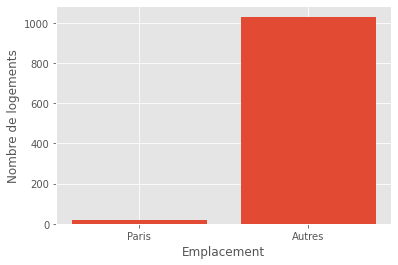

In [340]:
# Analyse graphique

import matplotlib.pyplot as plt

# Compter le nombre de logements à Paris et en dehors de Paris
paris_count = df.filter(col("Paris") == 1).count()
not_paris_count = df.filter(col("Paris") == 0).count()

# Créer le graphique à barres
plt.bar(["Paris", "Autres"], [paris_count, not_paris_count])
plt.xlabel("Emplacement")
plt.ylabel("Nombre de logements")
plt.show()


In [341]:
# Sélection des logements à Paris et en province
paris = df[df['Paris'] == 1]
province = df[df['Paris'] == 0]

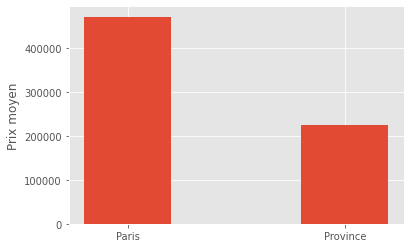

In [342]:
# calculer la moyenne de la colonne 'Prix' pour les logements à Paris
prix_moyen_paris = paris.agg(avg("Prix")).collect()[0][0]

# calculer la moyenne de la colonne 'Prix' pour les logements en province
prix_moyen_province = province.agg(avg("Prix")).collect()[0][0]

# Création du diagramme à barres
bar_width = 0.4
plt.bar(['Paris', 'Province'], [prix_moyen_paris, prix_moyen_province], width=bar_width)
plt.ylabel('Prix moyen')
plt.show()


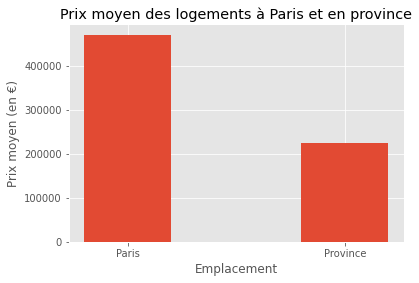

In [343]:
# Sélection des logements à Paris et en province
paris = df[df['Paris'] == 1]
province = df[df['Paris'] == 0]

# Calcul des prix moyens
prix_moyen_paris = paris.agg({'Prix':'mean'}).collect()[0][0]
prix_moyen_province = province.agg({'Prix':'mean'}).collect()[0][0]

# Création du diagramme à barres
bar_width = 0.4
plt.bar(['Paris', 'Province'], [prix_moyen_paris, prix_moyen_province], width=bar_width)

# Ajout de titres et de labels
plt.title("Prix moyen des logements à Paris et en province")
plt.xlabel("Emplacement")
plt.ylabel("Prix moyen (en €)")
plt.style.use('ggplot')
plt.show()


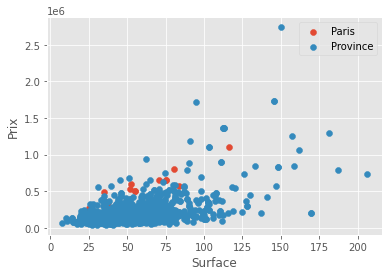

In [344]:
# Récupération des valeurs de la colonne "Prix" et "Surface" pour les appartements à Paris
x_paris = df.filter(df["Paris"] == 1).select("Surface").collect()
y_paris = df.filter(df["Paris"] == 1).select("Prix").collect()

# Récupération des valeurs de la colonne "Prix" et "Surface" pour les appartements en province
x_province = df.filter(df["Paris"] == 0).select("Surface").collect()
y_province = df.filter(df["Paris"] == 0).select("Prix").collect()

# Tracé des nuages de points pour les appartements à Paris et en province
plt.scatter(x_paris, y_paris, label="Paris")
plt.scatter(x_province, y_province, label="Province")

plt.xlabel("Surface")
plt.ylabel("Prix")
plt.legend()
plt.show()

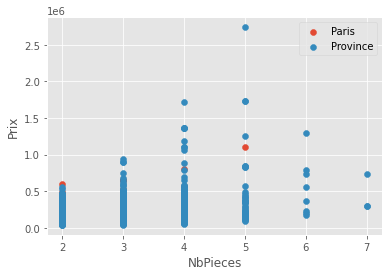

In [345]:
import matplotlib.pyplot as plt

# Récupération des valeurs de la colonne "Prix" et "NbPieces" pour les appartements à Paris
x_paris = df.filter(df["Paris"] == 1).select("NbPieces").collect()
y_paris = df.filter(df["Paris"] == 1).select("Prix").collect()

# Récupération des valeurs de la colonne "Prix" et "NbPieces" pour les appartements en province
x_province = df.filter(df["Paris"] == 0).select("NbPieces").collect()
y_province = df.filter(df["Paris"] == 0).select("Prix").collect()

# Tracé des nuages de points pour les appartements à Paris et en province
plt.scatter(x_paris, y_paris, label="Paris")
plt.scatter(x_province, y_province, label="Province")

plt.xlabel("NbPieces")
plt.ylabel("Prix")
plt.legend()
plt.show()


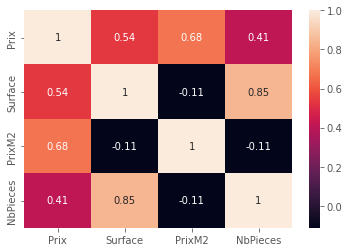

In [346]:
#Correlation entre les varaibles
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vars = ['Prix', 'Surface', 'PrixM2', 'NbPieces']

# Assemble les colonnes en un vecteur
vectorAssembler = VectorAssembler(inputCols = vars, outputCol = "corr_input")
df_vect = vectorAssembler.transform(df).select("corr_input")

# Calcule la matrice de corrélation
corr = Correlation.corr(df_vect, "corr_input").head()

# Convertit la matrice de corrélation en un dataframe pandas
corr_matrix = corr[0].toArray().tolist()
corr_matrix_pandas = pd.DataFrame(corr_matrix, columns=vars, index=vars)

# Tracé de la heatmap des corrélations
sns.heatmap(corr_matrix_pandas, annot=True)
plt.show()


In [347]:
# Tests statisques

from scipy import stats

# convertir le DataFrame en DataFrame pandas
df_pandas = df.toPandas()

# Test de Student pour chaque coefficient de corrélation
for var in ['Surface', 'PrixM2', 'NbPieces']:
    corr, p_value = stats.pearsonr(df_pandas[var], df_pandas['Prix'])
    if p_value < 0.05:
        print("La variable {} est statistiquement significative (p-value = {})".format(var, p_value))


La variable Surface est statistiquement significative (p-value = 4.215110739322898e-80)
La variable PrixM2 est statistiquement significative (p-value = 1.0582093752894403e-140)
La variable NbPieces est statistiquement significative (p-value = 1.8709875120648435e-44)


## Modélisation sous spark

In [348]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

vars = ['Surface', 'PrixM2', 'NbPieces','Paris']

# Assemblage des variables en un vecteur de features
vectorAssembler = VectorAssembler(inputCols=vars, outputCol="features")
df_vect = vectorAssembler.transform(df)

In [349]:
# Séparation des données en jeux d'entraînement et de test
(train, test) = df_vect.randomSplit([0.8, 0.2])

In [350]:
# Initialisation de l'objet de régression linéaire
lr = LinearRegression(featuresCol="features", labelCol="Prix", predictionCol="prediction")

# Initialisation de l'objet d'évaluation de la régression linéaire
evaluator = RegressionEvaluator(labelCol="Prix", predictionCol="prediction", metricName="rmse")

In [351]:
# Initialisation de l'objet de grid search
grid = ParamGridBuilder().build()

# Initialisation de l'objet de validation croisée
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, trainRatio=0.8)

In [352]:
# Entraînement du modèle
model = tvs.fit(train)

In [353]:
# Evaluation du modèle sur le jeu de test
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print("RMSE: %.3f" % rmse)

RMSE: 79839.041


In [354]:
# Initialisation de l'objet d'évaluation de la régression
evaluator = RegressionEvaluator(labelCol="Prix", predictionCol="prediction", metricName="r2")

# Calcul de R2
r2 = evaluator.evaluate(predictions)
print("R2: %.3f" % r2)

R2: 0.806


Modele pour streamlit

In [355]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# Convertir le DataFrame Spark en DataFrame Pandas
df_pd = df.toPandas()

vars_pd = ['Surface', 'NbPieces','Paris']

features=df_pd[vars_pd]

X_train, X_test, y_train, y_test = train_test_split(features,df_pd['Prix'], test_size=0.2, shuffle=True)

rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5)

grid_rf.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_rf.best_params_)

predictions_rf = grid_rf.predict(X_test)


Meilleurs paramètres :  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [356]:
# Créer une fonction pour extraire les codes postaux
def extract_postal_code(text):
    postal_code = re.findall(r'\b\d{5}\b', text)
    return postal_code[0] if postal_code else None

df_pd['Code_postal'] = df_pd['Adresse'].apply(extract_postal_code)

### API pour les coordonnées gps et fonction de création de geo.xlsx

In [357]:
''' from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
df_pd["coordonnees"] = df_pd["Code_postal"].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude) if x != None else None)
'''

' from geopy.geocoders import Nominatim\ngeolocator = Nominatim(user_agent="geoapiExercises")\ndf_pd["coordonnees"] = df_pd["Code_postal"].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude) if x != None else None)\n'

In [358]:
'''
df_pd[['latitude', 'longitude']] = df_pd['coordonnees'].apply(lambda x: pd.Series(x))
df_pd['latitude'] = pd.to_numeric(df_pd['latitude'], errors='coerce')
df_pd['longitude'] = pd.to_numeric(df_pd['longitude'], errors='coerce')
df_pd'''

"\ndf_pd[['latitude', 'longitude']] = df_pd['coordonnees'].apply(lambda x: pd.Series(x))\ndf_pd['latitude'] = pd.to_numeric(df_pd['latitude'], errors='coerce')\ndf_pd['longitude'] = pd.to_numeric(df_pd['longitude'], errors='coerce')\ndf_pd"

In [359]:
'''df_pd.to_excel('/content/drive/MyDrive/Pojet_py/geo.xlsx', index=False)'''

"df_pd.to_excel('/content/drive/MyDrive/Pojet_py/geo.xlsx', index=False)"

### Exporter le modele

In [360]:
'''
import pickle

with open('/content/drive/MyDrive/Pojet_py/model.pkl', 'wb') as file:
    pickle.dump(grid_rf, file)
'''

# Streamlit

In [361]:
!pip install streamlit -q

In [ ]:
!pip install geopandas

In [362]:
!pip install branca==0.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [372]:
%%writefile app.py
import streamlit as st
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import geopandas as gpd
import pickle
import folium
import matplotlib.pyplot as plt


with open('.../model.pkl', 'rb') as f:
    model = pickle.load(f)

df = pd.read_excel('.../Pojet_py/geo.xlsx')

st.set_page_config(page_title="Prédiction de prix d'un bien immobilier", page_icon=":house:", layout="wide")

st.title("Prédiction de prix d'un bien immobilier")

st.write("Cette application permet de d'estimer le prix d'un bien immobilier en fonction de sa surface, nombre de pièces et s'il est situé à Paris ou non.")

# Récupérer les informations de l'utilisateur
st.sidebar.title("Entrées")
surface = st.sidebar.number_input("Surface (en m²) : ")
nb_pieces = st.sidebar.number_input("Nombre de pièces : ")
paris = st.sidebar.selectbox("Est-ce à Paris ?", ["oui", "non"])
if paris == "oui":
    paris = 1
else:
    paris = 0

# Ajoutez un bouton pour prédire le prix
if st.button("Estimation"):
    features = [[surface, nb_pieces, int(paris)]]
    prediction = model.predict(features)
    st.write("Le prix de votre bien est estimé à :", prediction[0], "€")

# Geolocalisation 
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])

# Affichage de la map
st.title("Localisation des appartements")

# créer un GeoDataFrame à partir des données
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Créer une carte de fond avec folium
m = folium.Map(location=[48.866667, 2.333333], zoom_start=6)

for row in gdf.itertuples():
    folium.Marker(location=[row.latitude, row.longitude]).add_to(m)

st.write(m)

st.empty()
st.markdown('<br>'*1)
st.subheader("Analyse graphique de la base de données")

'''Graphiques'''

#Graphique1

# Calcul des prix moyens
prix_moyen_paris = df[df['Paris'] == 1]['Prix'].mean()
prix_moyen_province = df[df['Paris'] == 0]['Prix'].mean()

st.markdown("Prix moyen des logements à Paris et en province")

fig, ax = plt.subplots()
ax.scatter([1, 2, 3], [1, 2, 3])

# Création du diagramme à barres
bar_width = 0.4
plt.bar(['Paris', 'Province'], [prix_moyen_paris, prix_moyen_province], width=bar_width)

# Ajout de titres et de labels
plt.title("Prix moyen des logements à Paris et en province")
plt.xlabel("Emplacement")
plt.ylabel("Prix moyen (en €)")
# Utilisation d'un style de graphique plus élégant
plt.style.use('ggplot')

st.pyplot(fig)

#Graphique2

st.markdown("Relation entre le prix et la surface")

x_paris = df[df["Paris"] == 1]["Surface"].values
y_paris = df[df["Paris"] == 1]["Prix"].values

x_province = df[df["Paris"] == 0]["Surface"].values
y_province = df[df["Paris"] == 0]["Prix"].values

fig, ax = plt.subplots()
ax.scatter([1, 2, 3], [1, 2, 3])

# Tracé des nuages de points pour les appartements à Paris et en province
plt.scatter(x_paris, y_paris, label="Paris")
plt.scatter(x_province, y_province, label="Province")

# Ajout des titres aux axes
plt.xlabel("Surface")
plt.ylabel("Prix")
plt.legend()

st.pyplot(fig)



Overwriting app.py


In [373]:
!streamlit run app.py & npx localtunnel --port 8501

[############......] / finalize:y18n: sill finalize /root/.npm/_npx/149549/lib/

npx: installed 22 in 3.244s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.239.112.239:8501

your url is: https://true-singers-cross-35-239-112-239.loca.lt
  Stopping...
^C
